# Airbnb Business Questions

### The objective behind the following questions is to understand what drives pricing in Boston AirBnB listings and hence provide useful insights into what customers 'should look out for' when looking to book a stay in Boston. 

### What are the key factors for predicting price?

In [37]:
import pandas as pd
import os
from scipy import stats
from matplotlib import pyplot as plt
from utils.data_proc_utils import get_files, proc_calendar, listing_proc, listing_proc_dummies, listing_proc_drop
from utils.analysis_utils import identify_outliers, check_missing, check_missing_dict, find_redundent_columns, CustomImputer, get_ccp_path, optimise_dt, impute, normalise, optimal_regularisation, errors_to_df, get_optimal_model_params

In [104]:
top25_features = pd.read_csv(os.path.join(os.getcwd(), 'top_25.csv'))
colours = []
for i in top25_features['sign']:
    if i > 0:
        colours.append('g')
    else:
        colours.append('r')

### Below is a plot of standardised regressors from a lasso regression model with price as the dependent variable. Standardising regressors ensures all of the coefficients are expressed on the same scale and thus in terms of 'one standard deviation increases'. Ranking the standardised coefficients can give us a sense of the regressors which are most 'important'. Below I took the absolute value of the coefficients and indicate the regressors which have a negative association with price in red.  

### Key insights:
### (1) Size matters - an entire home/ apt comes at a substantial premium over a shared dwelling. Moreover price is also increasing in the number of bedrooms, bathrooms and overall amenities on offer. 
### (2) Location, location, location. Backbay, South End, South Boston Waterfront and Downtown are among the prime locations it comes to price
### (3) If you want to bring guests, be prepared to pay for the privilege.
### (4) Be mindful of cancellation policies. A listing with a super strict policy is likely to be indicative of an expensive dwelling.
### (5) Opportunities for a good price may exist if you're prepared to trade off some flexibility. For instance listings with greater minimum number of nights are associated with a lower price, all things being equal.

<AxesSubplot:ylabel='features'>

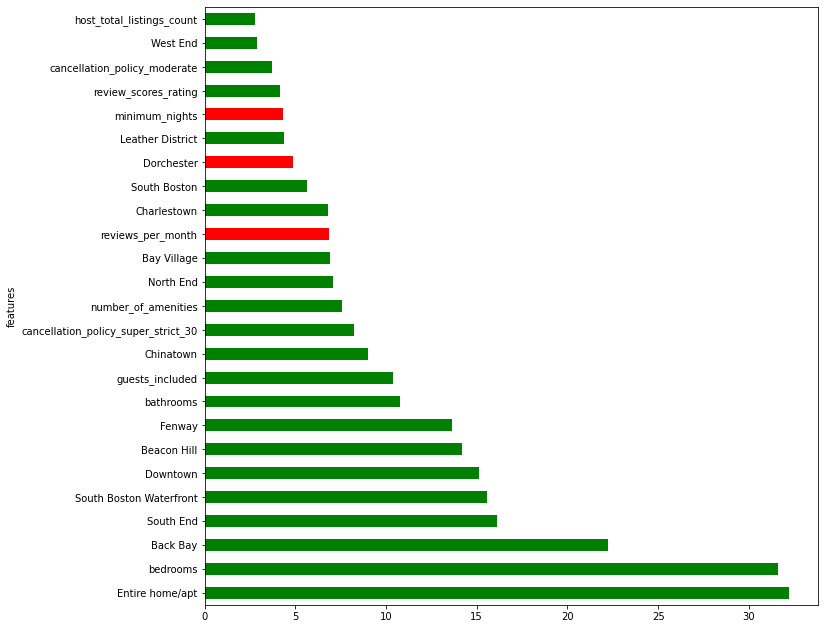

In [106]:
top25_features.plot.barh(x='features', y = 'coef_abs', color=colours, figsize=(11, 11), legend=False)

In [109]:
fig.savefig('top_features.png')

### Which neighbourhoods are the most desirable but present opportunities for a good deal?

In [39]:
all_data = get_files()
calendar_df, listings_df = all_data['calendar.csv'], all_data['listings.csv']
process_calendar = proc_calendar(calendar_df)
location_map = pd.Series(listings_df.neighbourhood_cleansed.values, index=listings_df.id.values).to_dict()
process_calendar['location'] = process_calendar['listing_id'].map(location_map)

In [44]:
processed_listings_df = listing_proc(listings_df)

In [49]:
price_review_mean = processed_listings_df.groupby('neighbourhood_cleansed')[['review_scores_rating', 'price']].mean()

### West Roxbury and Roslindale rank highly for reviews and are in the top 5 cheapest neighbours to stay in!

Text(0.5, 1.0, 'Price vs Rating')

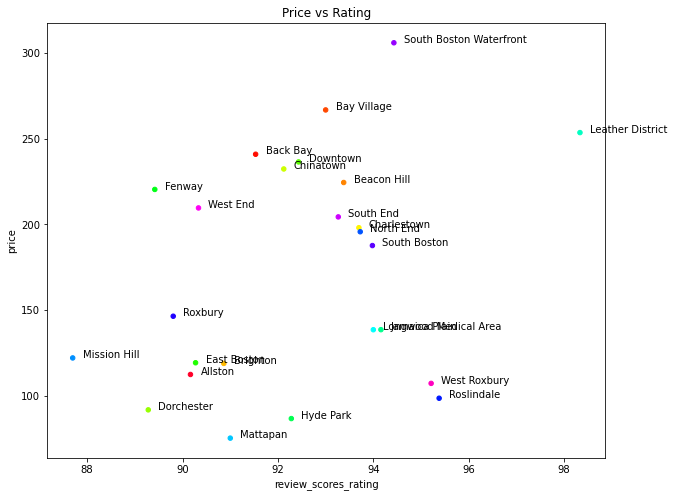

In [71]:
from matplotlib import cm
fig, ax = plt.subplots(figsize=(10,8))
colours = cm.get_cmap('gist_rainbow')
price_review_mean.plot.scatter('review_scores_rating', 'price', ax = ax, c = range(len(price_review_mean)), colormap = colours)
for i,j in price_review_mean.iterrows():
    ax.annotate(i,j, xytext=(10,0), textcoords='offset points')
plt.title("Price vs Rating")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

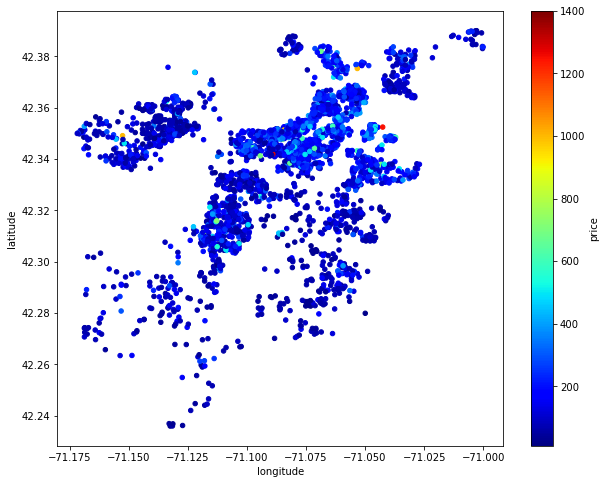

In [100]:
fig, ax = plt.subplots(figsize=(10,8))
processed_listings_df[processed_listings_df['price'] < 1500].plot.scatter(x = 'longitude', y = 'latitude', c = 'price', colormap='jet', ax = ax)

### When can you expect to get the best deals and when should you brace yourself to have to pay more?

In [22]:
all_data = get_files()
calendar_df = all_data['calendar.csv']
process_calendar = proc_calendar(calendar_df)

In [24]:
day_of_week_mean_price = process_calendar.groupby('day_of_week')['price'].apply(lambda x: stats.trim_mean(x, 0.05))

In [25]:
day_of_week_mean_price

day_of_week
Friday       183.536679
Monday       177.392110
Saturday     183.828860
Sunday       179.240203
Thursday     179.276991
Tuesday      176.931964
Wednesday    177.506861
Name: price, dtype: float64

<BarContainer object of 7 artists>

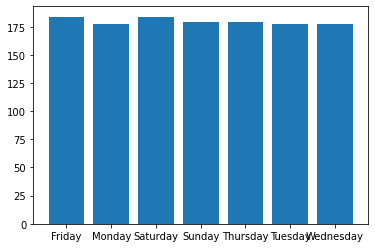

In [30]:
plt.bar(day_of_week_mean_price.index, day_of_week_mean_price.values)

In [32]:
date_mean_price = process_calendar.groupby('date')['price'].mean()

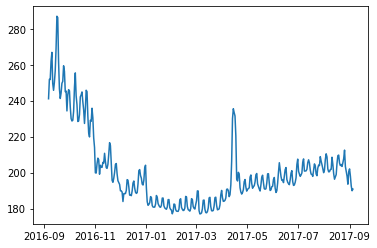

In [34]:
plt.plot(date_mean_price.index, date_mean_price.values)

In [35]:
process_calendar.head()

,listing_id,date,available,price,month,day_of_week
365,3075044,2017-08-22,True,65.0,8,Tuesday
366,3075044,2017-08-21,True,65.0,8,Monday
367,3075044,2017-08-20,True,65.0,8,Sunday
368,3075044,2017-08-19,True,75.0,8,Saturday
369,3075044,2017-08-18,True,75.0,8,Friday


In [75]:
months = {1 : 'Jan',
          2 : 'Feb',
          3 : 'Mar',
          4 : 'Apr', 
          5 : 'May',
          6 : 'Jun', 
          7 : 'Jul',
          8 : 'Aug',
          9 : 'Sep',
          10 : 'Oct', 
          11 : 'Nov',
          12 : 'Dec',}

In [96]:
month_mean_price = process_calendar.groupby('month')['price'].apply(lambda x: stats.trim_mean(x, 0.05))


In [91]:
month_mean_price['month_name'] = month_mean_price.index.map(months)

In [97]:
month_mean_price

month
1     168.083253
2     165.304264
3     164.733162
4     175.596921
5     173.724689
6     176.695548
7     179.227060
8     177.869893
9     221.001364
10    218.974275
11    187.590208
12    177.188510
Name: price, dtype: float64

In [113]:
processed_listings = listing_proc(listings_df)

In [116]:
processed_listings['cancellation_policy'].value_counts()


strict             1582
flexible            999
moderate            919
super_strict_30      85
Name: cancellation_policy, dtype: int64

In [118]:
mean_policy = processed_listings.groupby(['cancellation_policy'])['price'].mean()

### What impact does cancellation policy strictness have on price?

<AxesSubplot:xlabel='cancellation_policy'>

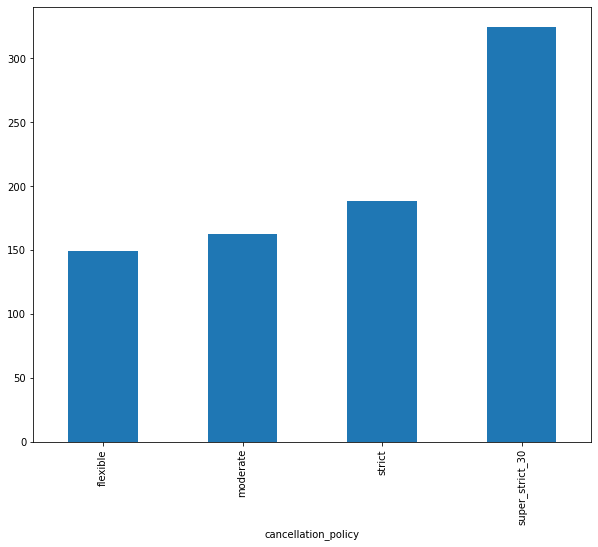

In [121]:
fig, ax = plt.subplots(figsize=(10,8))
mean_policy.plot.bar(x = mean_policy.index, y=mean_policy.values, ax = ax)